In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix, recall_score, precision_recall_fscore_support

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from utils import print_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("./data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
X = data.drop('Class', axis=1)
y = data['Class']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.20, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.transform(X_test)

**Modelo Base de Random Forest** 

In [4]:
modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)

print_score(modelo, X_train, y_train, X_val, y_val, train=True)
print_score(modelo, X_train, y_train, X_val, y_val, train=False)

Train Result:
Accuracy Score: 99.98%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.999833    1.000000  0.999848     0.999917      0.999849
recall        1.000000    0.998333  0.999848     0.999167      0.999848
f1-score      0.999917    0.999166  0.999848     0.999541      0.999848
support    6000.000000  600.000000  0.999848  6600.000000   6600.000000
_______________________________________________
Confusion Matrix: 
 [[6000    0]
 [   1  599]]

Validation Result:
Accuracy Score: 90.86%
_______________________________________________
CLASSIFICATION REPORT:
                     0      1  accuracy    macro avg  weighted avg
precision     0.909050    0.0  0.908636     0.454525      0.826409
recall        0.999500    0.0  0.908636     0.499750      0.908636
f1-score      0.952131    0.0  0.908636     0.476066      0.865574
support    2000.000000  200.0  0.908636  2200.000000   

> El modelo base Random Forest con sus parámetros por defecto, sufre de `sobreajuste` (overfitting), lo que significa que ha vuelto un experto en memorizar los datos de entrenamiento, pero no es capaz de detectar ningún fraude en datos que nunca ha visto, lo cual lo convierte en un modelo inútil.

In [5]:
#modelo.estimators_ es una lista de todos los árboles de decisión entrenados
profundidades = [arbol.get_depth() for arbol in modelo.estimators_]

print(f"El modelo tiene {len(profundidades)} árboles.")
print("-" * 30)
print(f"Profundidad máxima encontrada: {max(profundidades)}")
print(f"Profundidad mínima encontrada: {min(profundidades)}")
print(f"Profundidad promedio: {np.mean(profundidades):.2f}")

print("\nProfundidades de los primeros 10 árboles:")
print(profundidades[:10])

El modelo tiene 100 árboles.
------------------------------
Profundidad máxima encontrada: 33
Profundidad mínima encontrada: 21
Profundidad promedio: 25.85

Profundidades de los primeros 10 árboles:
[22, 23, 22, 22, 24, 25, 23, 23, 27, 24]


> El modelo cuenta con 100 árboles, esto árboles tienen una profundidad máxima de 33, la mínima de 21 y el promedio es de casi 26 niveles.
>
> Al no ponerle límites (max_depth=None) a los árboles, se permitió que cada árbol creciera sin control, lo que los llevó a seguir bajando y hacer preguntas muy específicas permitiendoles ser demasiados detallados, lo cual les permite aprende hasta el mínimo detalle y memorizarlo, por eso es que el modelo funciona tan bien en entrenamiento pero es pésimo en validación, porque son datos que nunca a visto, el modelo solo memoriza no sabe generalizar.

**Podar árboles:** Limitar la profundidad y que cada hoja tenga un número mínimo de ejemplos.

In [6]:
modelo_mejorado = RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=10, random_state=42)
modelo_mejorado.fit(X_train, y_train)

print_score(modelo_mejorado, X_train, y_train, X_val, y_val, train=True)
print_score(modelo_mejorado, X_train, y_train, X_val, y_val, train=False)

Train Result:
Accuracy Score: 90.91%
_______________________________________________
CLASSIFICATION REPORT:
                     0      1  accuracy    macro avg  weighted avg
precision     0.909091    0.0  0.909091     0.454545      0.826446
recall        1.000000    0.0  0.909091     0.500000      0.909091
f1-score      0.952381    0.0  0.909091     0.476190      0.865801
support    6000.000000  600.0  0.909091  6600.000000   6600.000000
_______________________________________________
Confusion Matrix: 
 [[6000    0]
 [ 600    0]]

Validation Result:
Accuracy Score: 90.91%
_______________________________________________
CLASSIFICATION REPORT:
                     0      1  accuracy    macro avg  weighted avg
precision     0.909091    0.0  0.909091     0.454545      0.826446
recall        1.000000    0.0  0.909091     0.500000      0.909091
f1-score      0.952381    0.0  0.909091     0.476190      0.865801
support    2000.000000  200.0  0.909091  2200.000000   2200.000000
_____________

> Al podar los árboles con max_depth, min_samples_leaf y min_samples_split, se ha resuelto el problema del sobreajuste, sin embargo, al hacerlo, se ha vuelto al problema inicial de nuestros datos, el desbalance de clases. El modelo actual, aunque ya no memoriza, sigue siendo incapaz de identificar el fraude, lo que lo mantiene siendo un modelo inútil.
>
> Ahora que el modelo no puede memorizar casos específicos (debido a la poda), se ve forzado a aprender reglas generales. Dado que la clase fraude, es la clase minoritaria, la estrategia por la que opta el modelo es ignorar por completo a la clase con menor cantidda e muestras, el algoritmo concluye que el costo de equivocarse al intentar predecir un fraude es mayor que el beneficio de acertar, por lo que adopta la política de siempre predecir la clase mayoritaria. 

**class_weight='balanced'**

In [7]:
modelo_balanceado = RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=10, class_weight='balanced', random_state=42)
modelo_balanceado.fit(X_train, y_train)

print_score(modelo_balanceado, X_train, y_train, X_val, y_val, train=True)
print_score(modelo_balanceado, X_train, y_train, X_val, y_val, train=False)

Train Result:
Accuracy Score: 94.68%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.970672    0.707846  0.946818     0.839259      0.946778
recall        0.970833    0.706667  0.946818     0.838750      0.946818
f1-score      0.970752    0.707256  0.946818     0.839004      0.946798
support    6000.000000  600.000000  0.946818  6600.000000   6600.000000
_______________________________________________
Confusion Matrix: 
 [[5825  175]
 [ 176  424]]

Validation Result:
Accuracy Score: 86.32%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.908217    0.075630  0.863182     0.491924      0.832527
recall        0.945000    0.045000  0.863182     0.495000      0.863182
f1-score      0.926244    0.056426  0.863182     0.491335      0.847169
support    2000.000000  200.000000 

> Al combinar la regularización para controlar el sobreajuste con el parámetro class_weight='balanced' para atacar el desbalanceo, el modelo ha aprendido a identificar transacciones fraudulentas, se ha pasado de un modelo que ignoraba por completo el fraude (Recall de 0.0) a uno que lo detecta, sin embargo, los resultados actuales generan muchas falsas alarmas, y todavía no es capaz de identificar correctamente todos los verdaderos positivos.

**Ajuste de hiperpárametros**

In [12]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid = {
    'n_estimators': [100, 200],         
    'max_depth': [7, 10, 15],           
    'min_samples_leaf': [10, 15, 20], 
    'max_features': ['sqrt', 'log2']    
}

f1_scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring=f1_scorer,  
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

print("Mejor F1-score durante la validación cruzada:")
print(grid_search.best_score_)

best_rf_model = grid_search.best_estimator_

y_pred_val = best_rf_model.predict(X_val)
print("Reporte de Clasificación en Validación")

print(classification_report(y_val, y_pred_val))
print(confusion_matrix(y_val, y_pred_val))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores parámetros encontrados:
{'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'n_estimators': 100}
Mejor F1-score durante la validación cruzada:
0.10188426898197005
Reporte de Clasificación en Validación
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      2000
           1       0.12      0.17      0.14       200

    accuracy                           0.81      2200
   macro avg       0.51      0.52      0.52      2200
weighted avg       0.84      0.81      0.82      2200

[[1750  250]
 [ 167   33]]


**Ajuste de umbral**

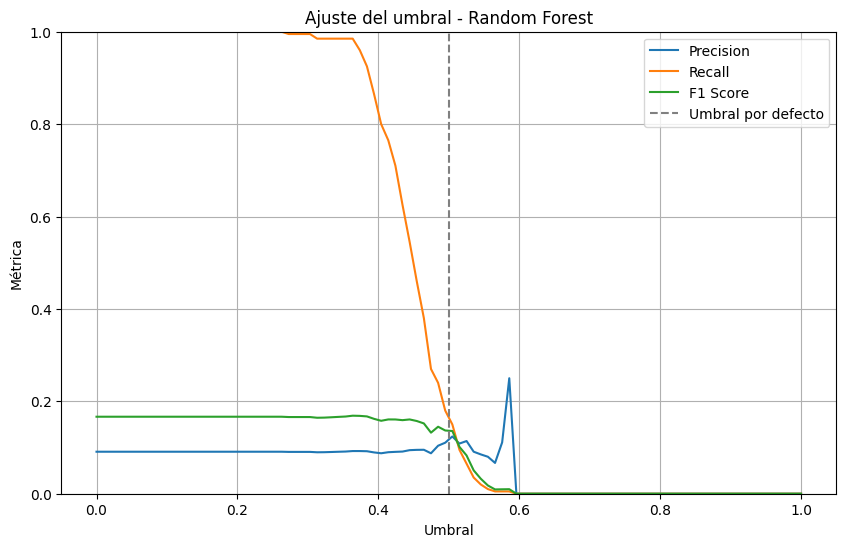

Mejor umbral: 0.364
Precision: 0.0924
Recall: 0.9850
F1-score: 0.1689


In [ ]:
probas_val = best_rf_model.predict_proba(X_val)[:, 1]  

thresholds = np.linspace(0, 1, 100)
precision_list, recall_list, f1_list = [], [], []

for t in thresholds:
    y_pred_t = (probas_val >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_val, y_pred_t, average='binary', pos_label=1
    )
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label="Precision")
plt.plot(thresholds, recall_list, label="Recall")
plt.plot(thresholds, f1_list, label="F1 Score")
plt.axvline(x=0.5, linestyle='--', color='gray', label="Umbral por defecto")
plt.xlabel("Umbral")
plt.ylabel("Métrica")
plt.title("Ajuste del umbral - Random Forest")
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

best_idx = np.argmax(f1_list)
best_thresh = thresholds[best_idx]

print(f"Mejor umbral: {best_thresh:.3f}")
print(f"Precision: {precision_list[best_idx]:.4f}")
print(f"Recall: {recall_list[best_idx]:.4f}")
print(f"F1-score: {f1_list[best_idx]:.4f}")

In [18]:
y_pred_opt = (probas_val >= best_thresh).astype(int)

print("\nEvaluación con umbral ajustado")
print(classification_report(y_val, y_pred_opt))
print("Matriz de confusión:\n", confusion_matrix(y_val, y_pred_opt))



Evaluación con umbral ajustado
              precision    recall  f1-score   support

           0       0.96      0.03      0.06      2000
           1       0.09      0.98      0.17       200

    accuracy                           0.12      2200
   macro avg       0.52      0.51      0.12      2200
weighted avg       0.88      0.12      0.07      2200

Matriz de confusión:
 [[  64 1936]
 [   3  197]]


In [19]:
probas_test = best_rf_model.predict_proba(X_test)[:, 1]
y_pred_test = (probas_test >= best_thresh).astype(int)

print("\nEvaluación final en conjunto de prueba con umbral ajustado")
print(classification_report(y_test, y_pred_test))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_test))



Evaluación final en conjunto de prueba con umbral ajustado
              precision    recall  f1-score   support

           0       0.86      0.04      0.07      2000
           1       0.09      0.94      0.16       200

    accuracy                           0.12      2200
   macro avg       0.47      0.49      0.12      2200
weighted avg       0.79      0.12      0.08      2200

Matriz de confusión:
 [[  73 1927]
 [  12  188]]


**SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

pipeline_smote = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(max_depth=10, min_samples_leaf=10, random_state=42))
])
pipeline_smote.fit(X_train, y_train)

print_score(pipeline_smote, X_train, y_train, X_val, y_val, train=True)
print_score(pipeline_smote, X_train, y_train, X_val, y_val, train=False)

Train Result:
Accuracy Score: 84.56%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.927114    0.227568  0.845606     0.577341      0.863519
recall        0.901000    0.291667  0.845606     0.596333      0.845606
f1-score      0.913870    0.255661  0.845606     0.584766      0.854033
support    6000.000000  600.000000  0.845606  6600.000000   6600.000000
_______________________________________________
Confusion Matrix: 
 [[5406  594]
 [ 425  175]]

Validation Result:
Accuracy Score: 81.41%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.907322    0.076923  0.814091     0.492123      0.831831
recall        0.886000    0.095000  0.814091     0.490500      0.814091
f1-score      0.896534    0.085011  0.814091     0.490773      0.822759
support    2000.000000  200.000000 

**Ajustar hiperpárametros**

In [21]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [150, 250],
    'classifier__max_depth': [8, 12, 16],        
    'classifier__min_samples_leaf': [10, 15],    
    'classifier__max_features': ['sqrt', 0.5]  
}

f1_scorer = make_scorer(f1_score, pos_label=1)

grid_search_smote = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5, 
    n_jobs=-1,
    verbose=2
)

print("Iniciando GridSearchCV con Pipeline de SMOTE...")
grid_search_smote.fit(X_train, y_train)

print("\nMejores parámetros para el Pipeline con SMOTE:")
print(grid_search_smote.best_params_)

print("\nMejor F1-score durante la validación cruzada:")
print(grid_search_smote.best_score_)

best_pipeline_model = grid_search_smote.best_estimator_
y_pred_val = best_pipeline_model.predict(X_val)

print("\n--- Reporte de Clasificación en Validación con el Pipeline Optimizado ---")
print(classification_report(y_val, y_pred_val))
print(confusion_matrix(y_val, y_pred_val))

Iniciando GridSearchCV con Pipeline de SMOTE...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Mejores parámetros para el Pipeline con SMOTE:
{'classifier__max_depth': 8, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 15, 'classifier__n_estimators': 150}

Mejor F1-score durante la validación cruzada:
0.0932162214437369

--- Reporte de Clasificación en Validación con el Pipeline Optimizado ---
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      2000
           1       0.08      0.14      0.10       200

    accuracy                           0.77      2200
   macro avg       0.49      0.49      0.48      2200
weighted avg       0.83      0.77      0.80      2200

[[1661  339]
 [ 171   29]]


**Ajustar umbral**

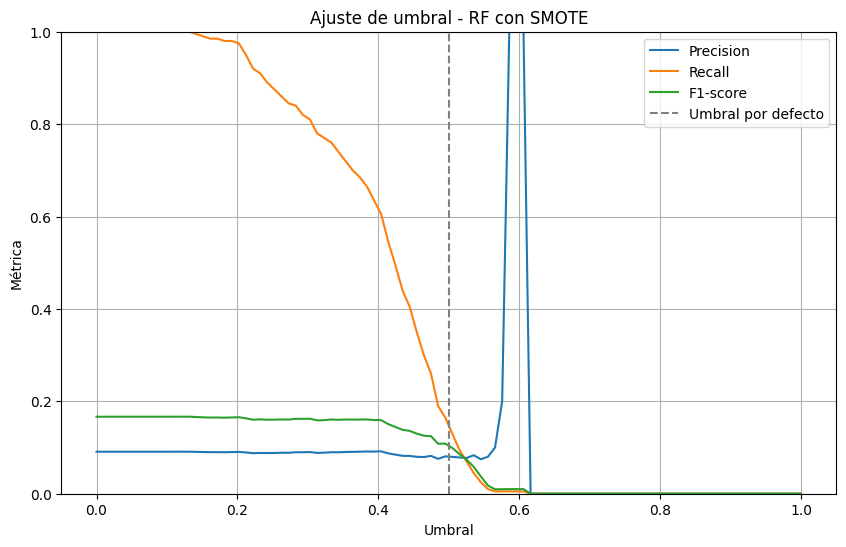

Umbral óptimo: 0.111
Precision: 0.0910
Recall: 1.0000
F1-score: 0.1667


In [ ]:
probas_val = best_pipeline_model.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0, 1, 100)
precision_list, recall_list, f1_list = [], [], []

for t in thresholds:
    y_pred_thresh = (probas_val >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_val, y_pred_thresh, average='binary', pos_label=1
    )
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label="Precision")
plt.plot(thresholds, recall_list, label="Recall")
plt.plot(thresholds, f1_list, label="F1-score")
plt.axvline(x=0.5, linestyle='--', color='gray', label="Umbral por defecto")
plt.xlabel("Umbral")
plt.ylabel("Métrica")
plt.title("Ajuste de umbral - RF con SMOTE")
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

best_idx = np.argmax(f1_list)
best_thresh = thresholds[best_idx]

print(f"Umbral óptimo: {best_thresh:.3f}")
print(f"Precision: {precision_list[best_idx]:.4f}")
print(f"Recall: {recall_list[best_idx]:.4f}")
print(f"F1-score: {f1_list[best_idx]:.4f}")

In [23]:
y_pred_val_thresh = (probas_val >= best_thresh).astype(int)

print("\nEvaluación en validación con umbral ajustado")
print(classification_report(y_val, y_pred_val_thresh))
print("Matriz de confusión:\n", confusion_matrix(y_val, y_pred_val_thresh))


Evaluación en validación con umbral ajustado
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      2000
           1       0.09      1.00      0.17       200

    accuracy                           0.09      2200
   macro avg       0.55      0.50      0.08      2200
weighted avg       0.92      0.09      0.02      2200

Matriz de confusión:
 [[   1 1999]
 [   0  200]]


**Undersampling**

In [9]:
print("Distribución original:", np.bincount(y_train))

undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train, y_train)

print("Distribución después del undersampling:", np.bincount(y_under))

rf_under = RandomForestClassifier(n_estimators=100, random_state=42)
rf_under.fit(X_under, y_under)

print_score(rf_under, X_under, y_under, X_val, y_val, train=True)
print_score(rf_under, X_train, y_train, X_val, y_val, train=False)


Distribución original: [6000  600]
Distribución después del undersampling: [600 600]


Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    600.0  600.0       1.0     1200.0        1200.0
_______________________________________________
Confusion Matrix: 
 [[600   0]
 [  0 600]]

Validation Result:
Accuracy Score: 50.14%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.908597    0.090411  0.501364     0.499504      0.834217
recall        0.502000    0.495000  0.501364     0.498500      0.501364
f1-score      0.646699    0.152896  0.501364     0.399797      0.601808
support    2000.000000  200.000000  0.501364  2200.000000   2200.000000
_______________________________

**Ajuste de hiperparámetros**

In [26]:
print("Distribución original:", np.bincount(y_train))

undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train, y_train)

print("Distribución después del undersampling:", np.bincount(y_under))

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [6, 8, 10],
    'min_samples_leaf': [10, 15],
    'max_features': ['sqrt', 0.5]
}

rf = RandomForestClassifier(random_state=42)
f1_scorer = make_scorer(f1_score, pos_label=1)

grid_search_rf = GridSearchCV(
    rf,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("Iniciando búsqueda de hiperparámetros...")
grid_search_rf.fit(X_under, y_under)

best_rf_under = grid_search_rf.best_estimator_
print("\nMejores parámetros encontrados:")
print(grid_search_rf.best_params_)


Distribución original: [6000  600]
Distribución después del undersampling: [600 600]
Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 24 candidates, totalling 120 fits



Mejores parámetros encontrados:
{'max_depth': 6, 'max_features': 0.5, 'min_samples_leaf': 15, 'n_estimators': 100}


**Ajuste de umbral**

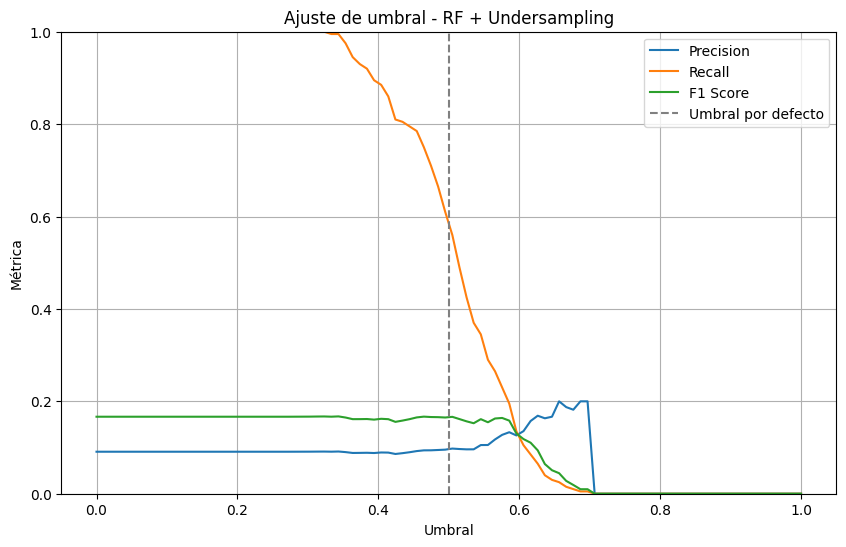


Mejor umbral: 0.343
Precision: 0.0914, Recall: 0.9950, F1-score: 0.1674


In [27]:
probas_val = best_rf_under.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0, 1, 100)
precision_list, recall_list, f1_list = [], [], []

for t in thresholds:
    y_pred_t = (probas_val >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_val, y_pred_t, average='binary', pos_label=1
    )
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.plot(thresholds, f1_list, label='F1 Score')
plt.axvline(x=0.5, linestyle='--', color='gray', label='Umbral por defecto')
plt.xlabel("Umbral")
plt.ylabel("Métrica")
plt.title("Ajuste de umbral - RF + Undersampling")
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

best_idx = np.argmax(f1_list)
best_thresh = thresholds[best_idx]
print(f"\nMejor umbral: {best_thresh:.3f}")
print(f"Precision: {precision_list[best_idx]:.4f}, Recall: {recall_list[best_idx]:.4f}, F1-score: {f1_list[best_idx]:.4f}")

In [ ]:
y_pred_val_thresh = (probas_val >= best_thresh).astype(int)

print("\nEvaluación en validación con umbral ajustado")
print(classification_report(y_val, y_pred_val_thresh))
print("Matriz de confusión:\n", confusion_matrix(y_val, y_pred_val_thresh))


Evaluación en validación con umbral ajustado
              precision    recall  f1-score   support

           0       0.95      0.01      0.02      2000
           1       0.09      0.99      0.17       200

    accuracy                           0.10      2200
   macro avg       0.52      0.50      0.09      2200
weighted avg       0.88      0.10      0.03      2200

Matriz de confusión:
 [[  21 1979]
 [   1  199]]


In [29]:
probas_test = best_rf_under.predict_proba(X_test)[:, 1]
y_pred_test_thresh = (probas_test >= best_thresh).astype(int)

print("\nEvaluación final en prueba con umbral ajustado")
print(classification_report(y_test, y_pred_test_thresh))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_test_thresh))


Evaluación final en prueba con umbral ajustado
              precision    recall  f1-score   support

           0       0.84      0.01      0.02      2000
           1       0.09      0.98      0.17       200

    accuracy                           0.10      2200
   macro avg       0.47      0.50      0.09      2200
weighted avg       0.77      0.10      0.03      2200

Matriz de confusión:
 [[  16 1984]
 [   3  197]]


Evaluación en el conjunto de prueba (con ajuste de umbral para maximizar F1-score en la clase fraude):_

| Técnica                      | Precision (fraude) | Recall (fraude) | F1-score (fraude) | Accuracy global |
|------------------------------|--------------------|------------------|-------------------|-----------------|
|  class_weight='balanced'     | 0.09               | 0.94             | 0.16              | 0.12            |
|  SMOTE                       | 0.09               | 1.00             | 0.17              | 0.09            |
|  Undersampling               | 0.09               | 0.98             | 0.17              | 0.10            |

> Los tres modelos logran detectar una alta proporción de fraudes (recall cercano al 100%) gracias al ajuste del umbral, sin embargo, todos lo hacen a costa de una gran cantidad de falsos positivos, lo que reduce notablemente la precisión y la utilidad del modelo en producción.

El modelo con SMOTE y el de Undersampling obtienen el mayor F1-score (0.17), aunque la diferencia con class_weight='balanced' es mínima, en términos de balance entre recall y precisión, ningún modelo logra una precisión aceptable (> 10%) por lo que en términos de mejor recall el mejor modelo es SMOTE.